Authors: Emre and Yash

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from graph import Graph, MVC  # MVC is in your graph.py

In [2]:
# Helper functions
def edge_set(G):
    """Return a set of undirected edges as (u, v) with u < v, without modifying G."""
    edges = set()
    for u in G.adj:
        for v in G.adj[u]:
            if u < v:
                edges.add((u, v))
    return edges

def degrees_from_edges(edges):
    """Compute degrees induced by the remaining edge set."""
    deg = {}
    for u, v in edges:
        deg[u] = deg.get(u, 0) + 1
        deg[v] = deg.get(v, 0) + 1
    return deg

def approx1(G):
    """
    Greedy: repeatedly take the vertex with highest degree (w.r.t. remaining edges),
    add it to cover, remove incident edges.
    """
    remaining = edge_set(G)
    C = set()

    while remaining:
        deg = degrees_from_edges(remaining)
        # pick a max-degree vertex; deterministic tie-break by vertex id
        v = max(deg.items(), key=lambda kv: (kv[1], -kv[0]))[0]

        C.add(v)
        remaining = {e for e in remaining if v not in e}

    return sorted(C)

def approx2(G):
    """
    Random vertex: pick a random vertex not already in C, add it,
    repeat until all edges are covered.
    """
    remaining = edge_set(G)
    C = set()
    nodes = list(G.adj.keys())

    # In worst case we may add all vertices, so bound loops by number of nodes
    while remaining and len(C) < len(nodes):
        candidates = [v for v in nodes if v not in C]
        if not candidates:
            break
        v = random.choice(candidates)

        C.add(v)
        remaining = {e for e in remaining if v not in e}

    return sorted(C)

def approx3(G):
    """
    Random edge: pick a random remaining edge (u,v), add both endpoints,
    remove all edges incident to either endpoint; repeat.
    """
    remaining = edge_set(G)
    C = set()

    while remaining:
        u, v = random.choice(tuple(remaining))
        C.add(u)
        C.add(v)
        remaining = {e for e in remaining if (u not in e and v not in e)}

    return sorted(C)

In [4]:

def create_random_graph(n, m):
    max_edges = n * (n - 1) // 2
    m = min(m, max_edges)
    G = Graph(n)
    all_edges = [(u, v) for u in range(n) for v in range(u+1, n)]
    for (u, v) in random.sample(all_edges, m):
        G.add_edge(u, v)
    return G

def eval_on_graph(G, repeats_rand=20):
    opt = len(MVC(G))

    a1 = len(approx1(G))

    # best-of-R for randomized
    a2 = min(len(approx2(G)) for _ in range(repeats_rand))
    a3 = min(len(approx3(G)) for _ in range(repeats_rand))

    return opt, a1, a2, a3

def run_vc_experiment(n=8, m_values=None, graphs_per_m=500, repeats_rand=20, seed=0):
    random.seed(seed)

    max_edges = n * (n - 1) // 2
    if m_values is None:
        m_values = list(range(1, max_edges + 1))

    mean_ratio = {"approx1": [], "approx2": [], "approx3": []}
    p90_ratio  = {"approx1": [], "approx2": [], "approx3": []}  # for graph 2

    for m in m_values:
        r1, r2, r3 = [], [], []
        for _ in range(graphs_per_m):
            G = create_random_graph(n, m)
            opt, a1, a2, a3 = eval_on_graph(G, repeats_rand=repeats_rand)

            # avoid division by zero (opt should never be 0 unless m=0)
            if opt == 0:
                continue

            r1.append(a1 / opt)
            r2.append(a2 / opt)
            r3.append(a3 / opt)

        mean_ratio["approx1"].append(float(np.mean(r1)))
        mean_ratio["approx2"].append(float(np.mean(r2)))
        mean_ratio["approx3"].append(float(np.mean(r3)))

        p90_ratio["approx1"].append(float(np.percentile(r1, 90)))
        p90_ratio["approx2"].append(float(np.percentile(r2, 90)))
        p90_ratio["approx3"].append(float(np.percentile(r3, 90)))

    return m_values, mean_ratio, p90_ratio

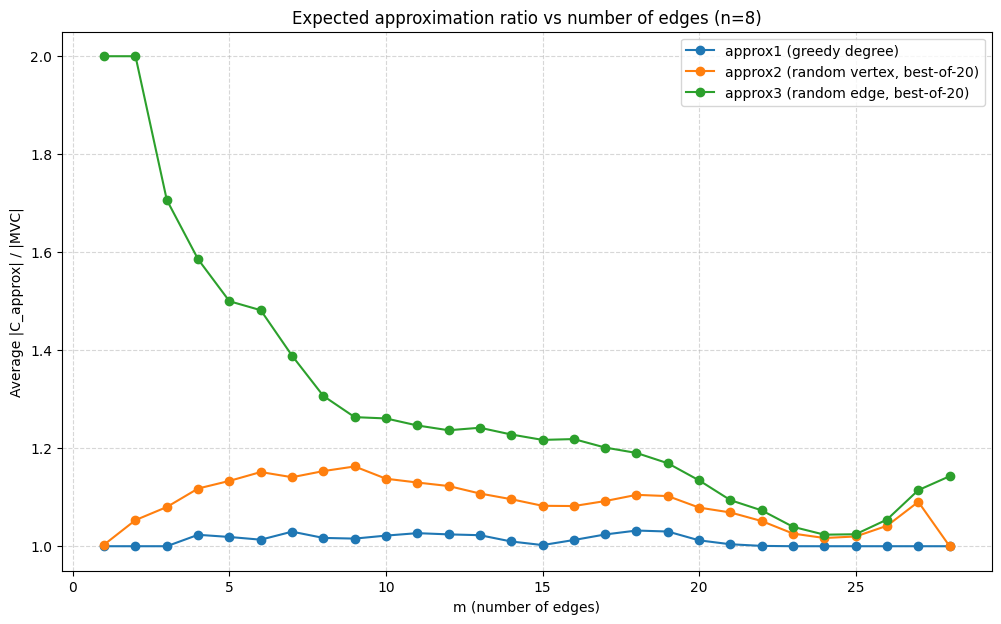

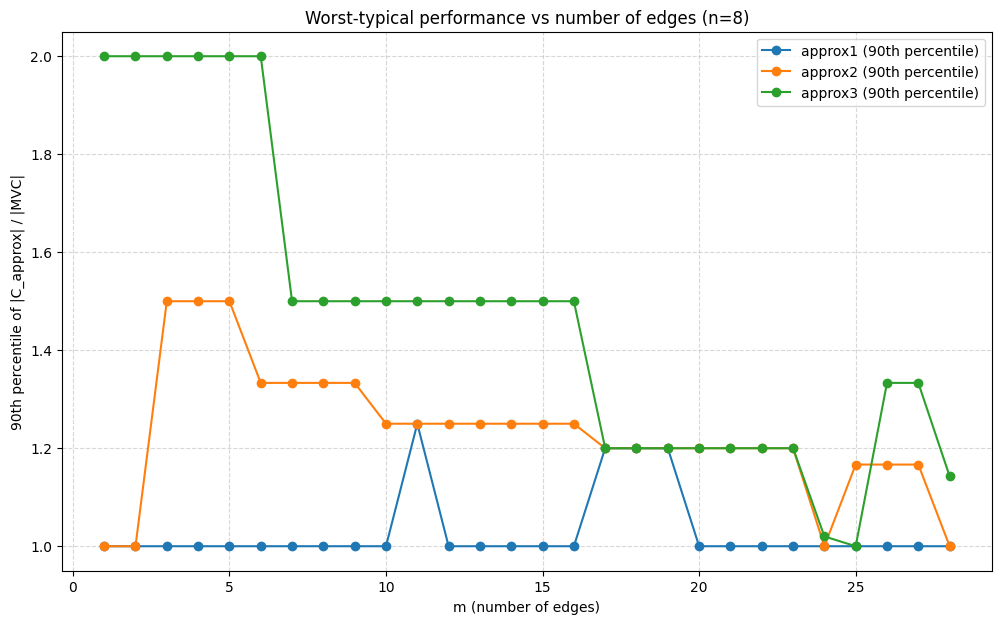

In [5]:
m_vals, mean_ratio, p90_ratio = run_vc_experiment(n=8, graphs_per_m=300, repeats_rand=20, seed=42)

# Graph 1: mean ratio vs m
plt.figure(figsize=(12,7))
plt.plot(m_vals, mean_ratio["approx1"], marker='o', label="approx1 (greedy degree)")
plt.plot(m_vals, mean_ratio["approx2"], marker='o', label="approx2 (random vertex, best-of-20)")
plt.plot(m_vals, mean_ratio["approx3"], marker='o', label="approx3 (random edge, best-of-20)")
plt.xlabel("m (number of edges)")
plt.ylabel("Average |C_approx| / |MVC|")
plt.title("Expected approximation ratio vs number of edges (n=8)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Graph 2: 90th percentile ratio vs m (risk)
plt.figure(figsize=(12,7))
plt.plot(m_vals, p90_ratio["approx1"], marker='o', label="approx1 (90th percentile)")
plt.plot(m_vals, p90_ratio["approx2"], marker='o', label="approx2 (90th percentile)")
plt.plot(m_vals, p90_ratio["approx3"], marker='o', label="approx3 (90th percentile)")
plt.xlabel("m (number of edges)")
plt.ylabel("90th percentile of |C_approx| / |MVC|")
plt.title("Worst-typical performance vs number of edges (n=8)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()